In [1]:
!pip install -U git+https://github.com/keras-team/keras git+https://github.com/keras-team/keras-applications

  Cloning https://github.com/keras-team/keras to /tmp/pip-req-build-ntjanncz
  Running command git clone -q https://github.com/keras-team/keras /tmp/pip-req-build-ntjanncz
  Cloning https://github.com/keras-team/keras-applications to /tmp/pip-req-build-vs5jklzk
  Running command git clone -q https://github.com/keras-team/keras-applications /tmp/pip-req-build-vs5jklzk
  Created wheel for Keras: filename=Keras-2.2.4-cp36-none-any.whl size=336023 sha256=d9872c244804ef19b6c219eb5cbaf04bcaee9f7b3da66bc1f9c8dcb805116f78
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6kk1ie4/wheels/18/59/26/2a3c8d65212670e9526dcb6966eba15ee401e814aa74ca121d
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

batch_size = 16
%matplotlib inline

In [0]:
path = '../content/gdrive/My Drive/Colab Notebooks/datasets/'
para = os.listdir(path + 'Parasites/')
un = os.listdir(path + 'Unpara/')

In [5]:
from keras.applications import resnet
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

resnet50 = resnet.ResNet50(include_top=True, weights='imagenet')

Using TensorFlow backend.
W0803 12:42:13.405953 140411587307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 12:42:13.452532 140411587307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 12:42:13.473701 140411587307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 12:42:13.527000 140411587307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:178: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 

102973440/102967424 [==============================] - 3s 0us/step


In [0]:
for layer in resnet50.layers:
    layer.trainable = False

In [0]:
def extract_features(img_paths, batch_size=batch_size):
    """ This function extracts image features for each image in img_paths using ResNet50 bottleneck layer.
        Returned features is a numpy array with shape (len(img_paths), 2048).
    """
    global resnet50
    n = len(img_paths)
    img_array = np.zeros((n, 224, 224, 3))
    
    for i, path in enumerate(img_paths):
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        x = preprocess_input(img)
        img_array[i] = x
    
    X = resnet50.predict(img_array, batch_size=batch_size, verbose=1)
    X = X.reshape(n, 1000, -1)
    return X

In [8]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
X = extract_features(
    list(map(lambda x: path + 'Parasites/' + x, para)) + list(map(lambda x: path + 'Unpara/' + x, un))
)
y = np.array([1] * len(para) + [0] * len(un))

307/307 [==============================] - 87s 283ms/step


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
def net():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return model

In [12]:
np.random.seed(42)

batch_size = 64
epochs = 15

model = net()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split = 0.3)

W0803 12:45:05.523231 140411587307392 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 12:45:05.631415 140411587307392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 149 samples, validate on 65 samples
Epoch 1/15
149/149 [==============================] - 1s 5ms/sample - loss: 0.6943 - acc: 0.4295 - val_loss: 0.6815 - val_acc: 0.9846
Epoch 2/15
149/149 [==============================] - 0s 164us/sample - loss: 0.6784 - acc: 0.9597 - val_loss: 0.6664 - val_acc: 0.9846
Epoch 3/15
149/149 [==============================] - 0s 140us/sample - loss: 0.6625 - acc: 1.0000 - val_loss: 0.6519 - val_acc: 0.9846
Epoch 4/15
149/149 [==============================] - 0s 138us/sample - loss: 0.6485 - acc: 1.0000 - val_loss: 0.6374 - val_acc: 1.0000
Epoch 5/15
149/149 [==============================] - 0s 175us/sample - loss: 0.6324 - acc: 1.0000 - val_loss: 0.6223 - val_acc: 1.0000
Epoch 6/15
149/149 [==============================] - 0s 146us/sample - loss: 0.6170 - acc: 1.0000 - val_loss: 0.6063 - val_acc: 1.0000
Epoch 7/15
149/149 [==============================] - 0s 163us/sample - loss: 0.6014 - acc: 1.0000 - val_loss: 0.5895 - val_acc: 1.0000
Epoch

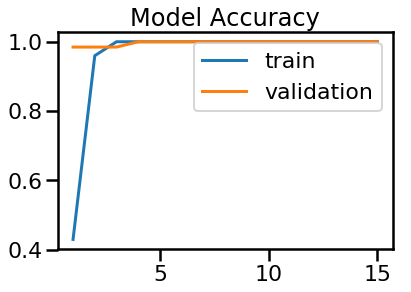

In [13]:
import seaborn as sns
sns.set_context('poster')
epochs = 15

plt.title("Model Accuracy")
plt.plot(range(1,epochs+1), history.history['acc'], label='train')
plt.plot(range(1,epochs+1), history.history['val_acc'], label='validation')
plt.legend();

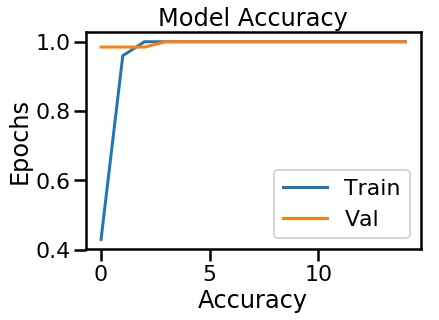

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

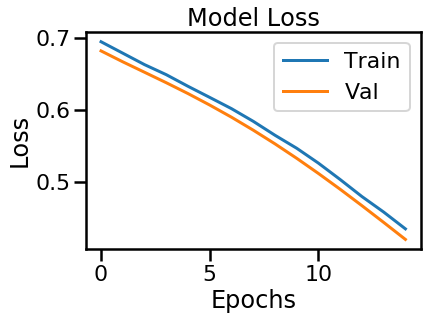

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [16]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test loss: {:.2%}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 42.57%
Test accuracy: 100.00%
